<a href="https://colab.research.google.com/github/ousmanezz/Underwater-Object-Detection/blob/main/Underwater_Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
import os

# Connect google drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/Underwater_Object_detection'
os.makedirs(save_dir, exist_ok=True)

print(f" Google Drive connected! Saving files to: {save_dir}")

Mounted at /content/drive
 Google Drive connected! Saving files to: /content/drive/MyDrive/Underwater_Object_detection


In [8]:

import shutil
import glob
import zipfile
!uv pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

os.system('pip uninstall -y kaggle kagglesdk')
os.system('pip install kaggle ultralytics')

os.environ['KAGGLE_API_TOKEN'] = "KGAT_365234e7f099b04243dd3d005a385823"
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

if not os.path.exists("underwater-plastic-pollution-detection.zip"):
    exit_code = os.system('kaggle datasets download -d arnavs19/underwater-plastic-pollution-detection')
    if exit_code != 0:
        raise RuntimeError(" Download Failed! Check your internet or token.")
else:
    print(" Zip file already exists. Skipping download.")

temp_dir = "temp_extraction"
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)

with zipfile.ZipFile("underwater-plastic-pollution-detection.zip", 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

base_dir = "yolo_underwater"
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

# Helper to find and move files
def find_and_move(split_name, search_keyword):
    # Create folders
    os.makedirs(f"{base_dir}/{split_name}/images", exist_ok=True)
    os.makedirs(f"{base_dir}/{split_name}/labels", exist_ok=True)
    images = glob.glob(f"{temp_dir}/**/*{search_keyword}*/**/*.jpg", recursive=True)

    if not images:
        images = glob.glob(f"{temp_dir}/**/*{search_keyword}*/*.jpg", recursive=True)

    print(f"   found {len(images)} images for {split_name}...")

    for img_path in images:
        filename = os.path.basename(img_path)

        # Move Image
        shutil.copy(img_path, f"{base_dir}/{split_name}/images/{filename}")

        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

        if not os.path.exists(label_path):
             label_path = img_path.replace(".jpg", ".txt")

        if os.path.exists(label_path):
            shutil.copy(label_path, f"{base_dir}/{split_name}/labels/{filename.replace('.jpg', '.txt')}")

# Run the finder
find_and_move("train", "train")
find_and_move("valid", "valid")
find_and_move("test", "test")


Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.4/235.7 GB disk)
 Zip file already exists. Skipping download.
   found 3628 images for train...
   found 1001 images for valid...
   found 501 images for test...


In [ ]:
 ## Training model
yaml_content = f"""
train: /content/{base_dir}/train/images
val: /content/{base_dir}/valid/images
test: /content/{base_dir}/test/images

nc: 15
names: ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove', 'metal', 'misc', 'net', 'pbag', 'pbottle', 'plastic', 'rod', 'sunglasses', 'tire']
"""

with open(f"{base_dir}/data.yaml", "w") as f:
    f.write(yaml_content)

print("Starting Training...")
model = YOLO('yolo11n.pt')
results = model.train(
    data="yolo_underwater/data.yaml",
    epochs=200,
    imgsz=640,
    project='/content/drive/MyDrive/Underwater_Object_detection',
    name='train_run',
    exist_ok=True
)

Starting Training...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_underwater/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

🔍 Searching for Plastic Bottles (Class ID 10)...
✅ Found 122 images containing Plastic Bottles.
📸 Running detection on the first 5 bottles found...


0: 640x640 1 pbottle, 5.4ms
1: 640x640 1 pbottle, 5.4ms
2: 640x640 1 pbag, 1 pbottle, 5.4ms
3: 640x640 1 pbottle, 5.4ms
4: 640x640 5 pbottles, 5.4ms
Speed: 2.7ms preprocess, 5.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


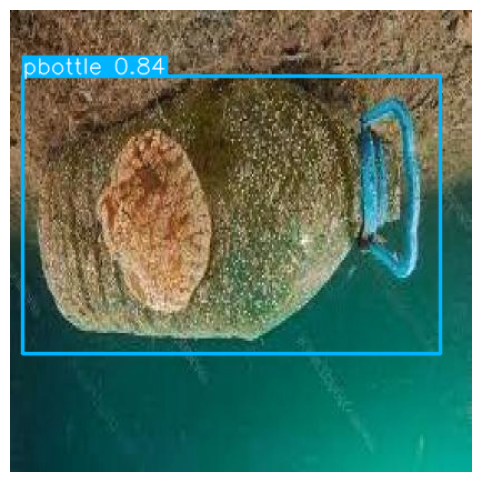

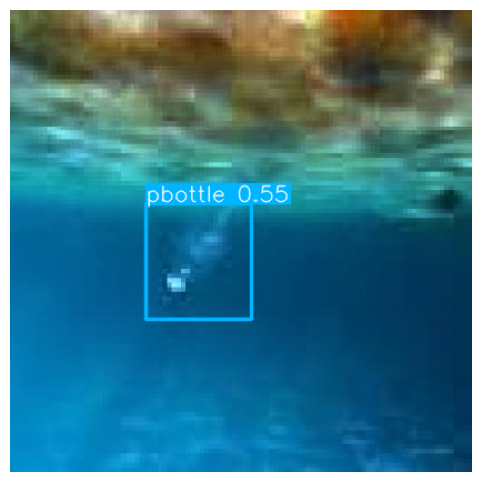

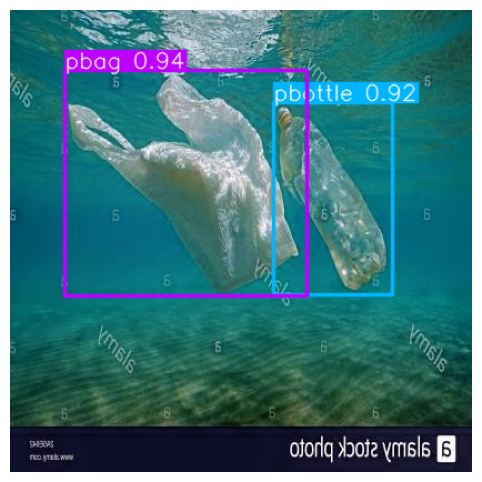

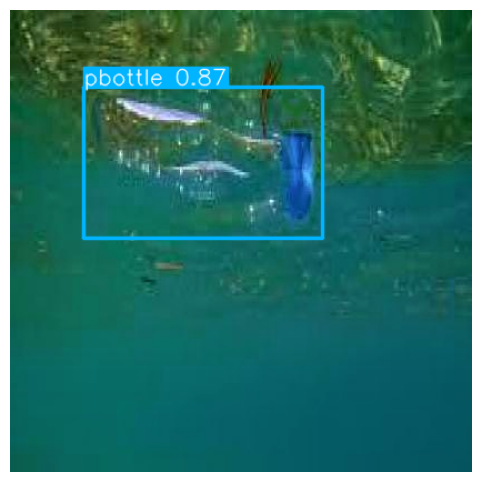

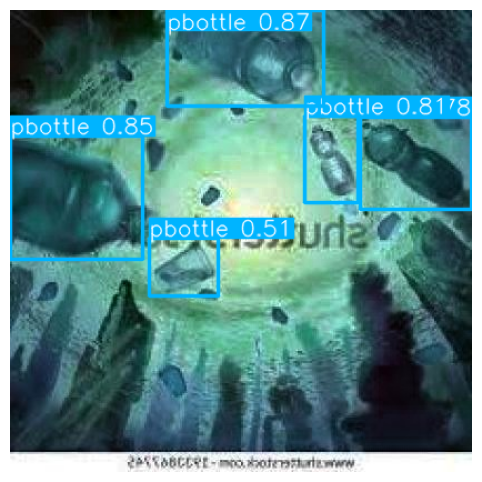

In [5]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- STEP 1: SETUP ---
# Load your trained model (make sure this path matches your best.pt)
# If you are still training, you can use 'last.pt' or wait for 'best.pt'
model_path = 'runs/detect/underwater_production/weights/best.pt'

# If you haven't finished the big training yet, use the one from the quick run:
if not os.path.exists(model_path):
    model_path = 'runs/detect/train/weights/best.pt'

model = YOLO(model_path)

# Define where your validation data lives
label_folder = "yolo_underwater/valid/labels"
image_folder = "yolo_underwater/valid/images"

print("🔍 Searching for Plastic Bottles (Class ID 10)...")

bottle_images = []

for label_file in glob.glob(f"{label_folder}/*.txt"):
    with open(label_file, 'r') as f:
        lines = f.readlines()

    # gbottle is class 10
    has_bottle = False
    for line in lines:
        if line.strip().startswith("10 "):
            has_bottle = True
            break

    if has_bottle:
        base_name = os.path.basename(label_file).replace(".txt", "")
        img_path = f"{image_folder}/{base_name}.jpg"

        if os.path.exists(img_path):
            bottle_images.append(img_path)

print(f" Found {len(bottle_images)} images containing Plastic Bottles.")

# --- STEP 3: TEST AND SHOW ---
if len(bottle_images) > 0:
    # We pick the first 5 images to show
    subset = bottle_images[5:10]

    # Run the model
    results = model.predict(subset, conf=0.25)
    for result in results:
        # Plot result
        img_array = result.plot()
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()
else:
    print(" No plastic bottles found in the validation folder!")